<a href="https://colab.research.google.com/github/MinghanChu/DeepLearning-ZerosToGans/blob/main/Training_Deep_NN_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 23469226.48it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1245060.73it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8111226.64it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7830057.04it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

image.shape: torch.Size([1, 28, 28])
Label: 5


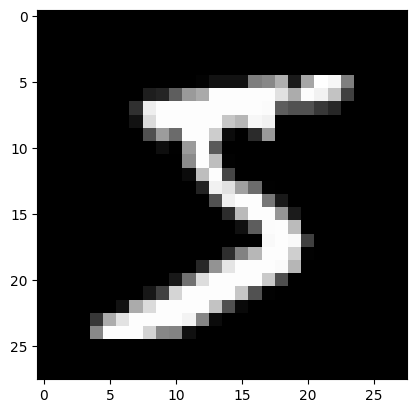

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


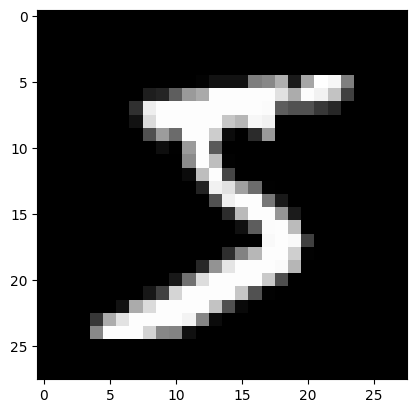

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [6]:
batch_size=128

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


+ `num_workers=4`: Setting the argument num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processes

+ setting `pin_memory=True`, which enables **fast data transfer to CUDA-enabled GPUs**

+ setting `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different.

+ note no need to set `shuffle=True` for the validation data loader because the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


images.shape: torch.Size([128, 1, 28, 28])


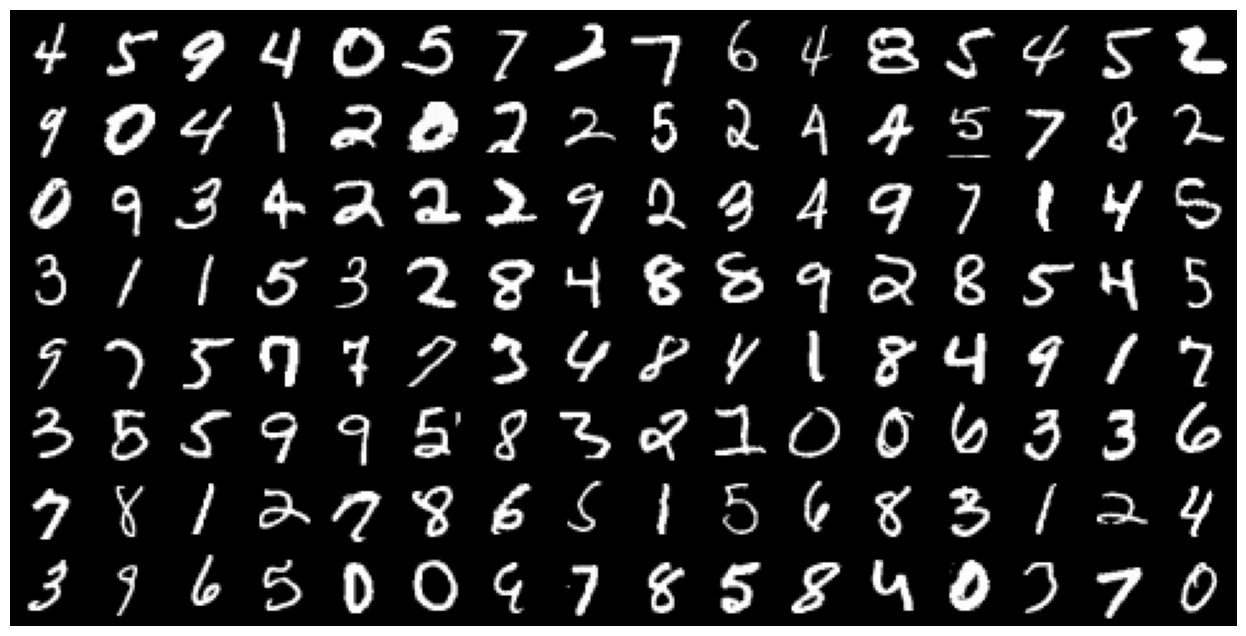

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a *hidden layer* and an *output layer*. Additionally, we'll use an activation function between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture **non-linear relationships** between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our `hidden` layer. (Note the hidden layer is a linear model.) We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the *learning capacity* of the model.

In [10]:
input_size = inputs.shape[-1]
hidden_size = 32

In [11]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`.

In [14]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [15]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture line relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [16]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values **were replaced with 0**.

In [17]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6302464008331299
min(relu_outputs): 0.0


Applying nonlinear activation function, `relu_outputs` and `inputs` do not have a linear relationship, e.g., `nn.Linear`. For each input certain outputs are activated (those with nonzero values) while others turned off (those with zero values).

Next, convert vectors of length `hidden_size` (originally not 10, in this particular example it is 32) in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

Let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model.

+ Mathematically: `output = input * weight^T + bias`

In [23]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size) # layer 2 is also based on a linear model
print(hidden_size)
print(output_size)

32
10


The nn.Linear layer in PyTorch (and similarly in many other deep learning frameworks) is designed to work with the feature dimension, which is always the second dimension of the input tensor when the input is a 2D tensor (i.e., batches of samples).

The call `layer2_outputs = layer2(relu_outputs)` will only work correctly if the size of `relu_outputs` is compatible with the expected input size of `layer2`

`layer2 = nn.Linear(hidden_size, output_size)` initializes a linear layer expecting input with `hidden_size` features.

`layer2(relu_outputs)` will work if `relu_outputs` has a shape `[batch_size, hidden_size]`

Ensure `hidden_size`in `nn.Linear(hidden_size, output_size)` matches the second dimension of `relu_outputs`

In [26]:
layer2_outputs = layer2(relu_outputs)
print(relu_outputs.shape)
print(layer2_outputs.shape)


torch.Size([128, 32])
torch.Size([128, 10])


As expected, `layer2_outputs` contains a batch of vectors of size 10. We can  now use this output to compute the loss using `F.cross_entropy`

In [20]:
inputs.shape

torch.Size([128, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [21]:
labels

tensor([2, 6, 3, 2, 7, 3, 7, 5, 0, 9, 7, 9, 7, 9, 9, 7, 1, 6, 7, 2, 4, 7, 1, 8,
        1, 6, 8, 9, 4, 0, 8, 1, 6, 7, 8, 6, 4, 7, 8, 6, 7, 9, 0, 9, 2, 1, 2, 8,
        0, 0, 6, 0, 1, 2, 2, 3, 3, 6, 5, 5, 9, 8, 0, 9, 1, 7, 9, 5, 0, 6, 7, 9,
        2, 9, 6, 8, 1, 3, 1, 5, 4, 6, 7, 0, 8, 3, 5, 9, 9, 0, 8, 1, 0, 1, 2, 6,
        2, 6, 1, 9, 3, 0, 8, 0, 2, 6, 2, 5, 3, 1, 0, 9, 8, 9, 4, 3, 0, 6, 3, 1,
        2, 3, 7, 9, 2, 2, 6, 5])

Thus, our model transforms

In [22]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2914, grad_fn=<NllLossBackward0>)